In [142]:
#!pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0.3 -q

In [143]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
import mesa

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib.lines as lines

import pandas as pd
import seaborn as sns
import numpy as np
import random
import heapq
from enum import Enum
from collections import defaultdict
from typing import Dict, List, Tuple

sns.set()
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.figsize'] = (5, 5)

In [144]:
wall_type = [0, 1, 2, 3, 4] # 0: none, 1: wall 1hp, 2: wall 2hp, 3: open door
                              # 4: closed door

grid_layout = [[(2, 0, 2, 2), (2, 0, 2, 0), (2, 4, 2, 0), (2, 0, 0, 4), (2, 0, 0, 0), (2, 2, 0, 0), (2, 0, 0, 2), (2, 2, 0, 0)],
               [(2, 0, 0, 2), (2, 0, 0, 0), (2, 2, 0, 0), (0, 0, 2, 2), (0, 0, 2, 0), (0, 4, 4, 0), (0, 0, 0, 4), (0, 2, 0, 0)],
               [(0, 0, 0, 3), (0, 0, 2, 0), (0, 2, 0, 0), (2, 0, 0, 2), (2, 0, 0, 0), (4, 2, 0, 0), (0, 0, 0, 2), (0, 2, 0, 0)],
               [(0, 2, 4, 2), (2, 2, 0, 2), (0, 2, 0, 2), (0, 0, 2, 2), (0, 0, 0, 0), (0, 2, 0, 0), (0, 0, 2, 2), (0, 2, 2, 0)],
               [(4, 0, 0, 2), (0, 2, 0, 0), (0, 0, 2, 2), (2, 3, 2, 0), (0, 0, 4, 3), (0, 3, 2, 0), (2, 0, 0, 3), (2, 3, 0, 0)],
               [(0, 0, 2, 2), (0, 0, 2, 0), (2, 0, 2, 0), (2, 0, 2, 0), (4, 0, 2, 0), (2, 2, 2, 0), (0, 0, 2, 2), (0, 2, 2, 0)]
               ]

grid_data = np.array(grid_layout)

In [145]:
class FireState(Enum):
  CLEAR = 0
  SMOKE = 1
  FIRE = 2

class POIType(Enum):
  VICTIM = "victim"
  FALSE = "false_alarm"

class FireFighterRole(Enum):
  RESCUER = "rescuer"
  EXTINGUISHER = "extinguisher"

class POI:
  def __init__(self, poi_id, poi_type, x, y):
    self.id = poi_id
    self.type = poi_type
    self.x = x
    self.y = y
    self.revealed = False

In [146]:
class FireAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(model)
    self.action_points = 4
    self.role = None
    self.target_poi = None
    self.carrying_victim = None
    self.knockout_timer = 0
    self.max_knockout_time = 2
    self.path = []
    self.unique_id = unique_id

  def reset_ap(self):
    self.action_points = 4

  def is_knocked_out(self):
    return self.knockout_timer > 0

  def update_knockout(self):
    if self.knockout_timer > 0:
      self.knockout_timer -= 1
      if self.knockout_timer == 0:
        self.action_points = 4
        self.respawn_agent()

  def respawn_agent(self):
    print(f"Agente {self.unique_id} respawneando desde {self.pos}")
    if self.carrying_victim:
      self.carrying_victim = None

    new_position = self.find_valid_respawn_position()
    if new_position:
      print(f"Agente {self.unique_id} respawneo en {new_position}")
      self.model.grid.move_agent(self, new_position)

    self.path = []

  def find_valid_respawn_position(self):
    valid_positions = []
    for y in range (self.model.height):
      for x in range (self.model.width):
        if self.model._get_fire_state(x, y) == FireState.CLEAR:
          if not any(poi.x == x and poi.y == y for poi in self.model.active_pois):
            # Ya no verificamos si la celda está vacía porque ahora permitimos múltiples agentes
            valid_positions.append((x, y))

    if valid_positions:
      return random.choice(valid_positions)

    return None

  def check_knockout(self):
    if self.pos and not self.is_knocked_out():
      fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
      if fire_state == FireState.FIRE:
        self.knockout_timer = self.max_knockout_time
        print(f"Agente {self.unique_id} noqueado por fuego en la pocision {self.pos}!")

  def step(self):
    self.reset_ap()
    self.update_knockout()

    if self.is_knocked_out():
      print(f"Agente {self.unique_id}: Esta noqueado mi pa, saltando su turno LOL")
      return

    if self.role is None:
      if self.carrying_victim:
        self.role = FireFighterRole.RESCUER
      else:
        self.role = FireFighterRole.EXTINGUISHER

    if self.role == FireFighterRole.RESCUER:
      self.rescuer_behavior()
    elif self.role == FireFighterRole.EXTINGUISHER:
      self.extinguisher_behavior()

    self.check_knockout()

  def rescuer_behavior(self):
    if self.carrying_victim:
      exits = [(0, 2), (7, 4)]
      target_exit = self.get_nearest_exit(exits)
      if target_exit is None:
        print(f"ERROR: Agente {self.unique_id} - No encuentra la salida LOL")
        return

      print(f"Agente {self.unique_id}: acarreando victima {self.carrying_victim.id}, posicion actual: {self.pos}, salida a la que va: {target_exit}")

      if self.pos == target_exit:
        print(f"Victima salvada por FireFighter {self.unique_id}!")
        rescued_victim = self.carrying_victim
        self.carrying_victim = None
        self.model.rescue_victims(rescued_victim)
        return

      current_fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
      if current_fire_state == FireState.FIRE:
        self.extinguish_fire(self.pos[0], self.pos[1])
        return

      print(f"Agente {self.unique_id} moviendo a la salida: {target_exit}")
      self.move_with_fire_handling(target_exit)

    elif self.target_poi:
      if self.pos == (self.target_poi.x, self.target_poi.y):
        self.reveal_and_handle_poi()
        return

      current_fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
      if current_fire_state == FireState.FIRE:
        self.extinguish_fire(self.pos[0], self.pos[1])
        return

      print(f"Agente {self.unique_id}: Yendo al POI: ({self.target_poi.x}, {self.target_poi.y})")
      self.move_with_fire_handling((self.target_poi.x, self.target_poi.y))

    else:
      nearby_fire = self.find_nearest_fire()
      if nearby_fire and self.action_points > 0:
        if self.pos == nearby_fire:
          self.extinguish_fire(nearby_fire[0], nearby_fire[1])
        else:
          self.move_towards_target(nearby_fire)

  def extinguisher_behavior(self):
    while self.action_points > 0:
      target = self.find_nearest_fire()
      if target:
        if self.pos == target:
          self.extinguish_fire(target[0], target[1])
        else:
          moved = self.move_towards_target(target)
          if not moved:
            break
      else:
        break

  def move_with_fire_handling(self, target):
    while self.action_points > 0:
      if self.pos == target:
        break

      current_fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
      if current_fire_state in [FireState.FIRE, FireState.SMOKE]:
        self.extinguish_fire(self.pos[0], self.pos[1])
        return
      moved = self.move_towards_target(target)
      if not moved:
        break

      new_fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
      if new_fire_state == FireState.FIRE:
        self.extinguish_fire(self.pos[0], self.pos[1])
        return

  def find_nearest_fire(self):
    best_target = None
    best_distance = float('inf')

    for y in range(self.model.height):
      for x in range(self.model.width):
        fire_state = self.model._get_fire_state(x, y)
        if fire_state in [FireState.FIRE, FireState.SMOKE]:
          distance = abs(x - self.pos[0]) + abs(y - self.pos[1])
          if distance < best_distance:
            best_target = (x, y)
            best_distance = distance

    return best_target

  def extinguish_fire(self, x, y):
    fire_state = self.model._get_fire_state(x, y)

    if fire_state == FireState.FIRE:
      if self.action_points >= 2:
        self.action_points -= 2
        self.model._set_fire_state(x, y, FireState.CLEAR)
      elif self.action_points >= 1:
        self.action_points -= 1
        self.model._set_fire_state(x, y, FireState.SMOKE)
    elif fire_state == FireState.SMOKE:
      if self.action_points >= 1:
        self.action_points -= 1
        self.model._set_fire_state(x, y, FireState.CLEAR)

  def get_nearest_exit(self, exits):
    best_exit = None
    best_distance = float('inf')

    for exit in exits:
      distance = abs(exit[0] - self.pos[0]) + abs(exit[1] - self.pos[1])
      if distance < best_distance:
        best_exit = exit
        best_distance = distance

    return best_exit

  def reveal_and_handle_poi(self):
    if self.action_points > 0:
      print(f"Agente {self.unique_id} encontro un POI en {self.target_poi.x}, {self.target_poi.y}")
      reveal_success = self.model.reveal_poi(self.target_poi.x, self.target_poi.y)
      if reveal_success:
        if self.target_poi != None:
          if self.target_poi.type == POIType.VICTIM and self.target_poi not in self.model.lost_victims:
            self.carrying_victim = self.target_poi
            print(f"Agente {self.unique_id} acarreando {self.target_poi.id}")
            if self.target_poi in self.model.active_pois:
              self.model.active_pois.remove(self.target_poi)

            new_poi = self.model.place_new_poi()
            if new_poi:
              print(f"Nuevo POI en {new_poi.x}, {new_poi.y})")

      self.target_poi = None
      self.action_points -= 1

  def move_towards_target(self, target):
    if self.action_points <= 0:
      return False

    if not self.path or (len(self.path) > 0 and self.path[-1] != target):
      print(f"Nuevo Path desde {self.pos} hasta {target}")
      self.path = self.djikstra(self.pos, target)
      print(f"Agente {self.unique_id} path: {self.path}")

    if self.path and len(self.path) > 1:
      next_pos = self.path[1]
      cost = self.get_move_cost(self.pos, next_pos)
      if self.action_points >= cost:
        wall_type, wall_dir = self.model._get_wall_between_cells(self.pos[0], self.pos[1], next_pos[0], next_pos[1])
        if wall_type == 0 or wall_type == 3:
          self.model.grid.move_agent(self, next_pos)
          self.action_points -= cost
          self.path.pop(0)
          if self.carrying_victim:
            self.carrying_victim.x = self.pos[0]
            self.carrying_victim.y = self.pos[1]
            print(f"Agente {self.unique_id}: se movio a {self.pos} con una victima")
          return True
        elif wall_type == 4:
          self.open_door(self.pos[0], self.pos[1], wall_dir)
          self.path.pop(0)
          return True
        else:
          self.path = []
          return False
      else:
        return False
    return False

  def get_move_cost(self, pos, next_pos):
    wall_type, _ = self.model._get_wall_between_cells(pos[0], pos[1], next_pos[0], next_pos[1])
    if wall_type == 0 or wall_type ==3:
      return 1
    elif wall_type == 4:
      return 2
    else:
      return float('inf')

  def chop_wall(self, x, y, direction):
    if self.action_points >= 1:
      success = self.model.damage_wall(x, y, direction)
      self.action_points -= 1

  def open_door(self, x, y, direction):
    if self.action_points >= 1 and 0 <= x < self.model.width and 0 <= y < self.model.height:
      if self.model.grid_data[y, x, direction] == 4:
        self.model.grid_data[y, x, direction] = 3
        self.action_points -= 1
        print(f"Agente {self.unique_id} abrio puerta ({x}, {y})")

  def djikstra(self, start, goal):
    if start == goal:
      return [start]

    g_score = {start: 0}
    open_set = [(g_score[start], start)]
    came_from = {}
    visited = set()

    while open_set:
      current_distance, current = heapq.heappop(open_set)

      if current in visited:
        continue

      visited.add(current)

      if current == goal:
        path = []
        while current in came_from:
          path.append(current)
          current = came_from[current]
        path.append(start)
        path.reverse()
        return path

      neighbors = self.get_neighbors(current)
      for neighbor in neighbors:
        if neighbor in visited:
          continue

        tentative_g_score = g_score[current] + self.get_move_cost(current, neighbor)

        if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
          came_from[neighbor] = current
          g_score[neighbor] = tentative_g_score
          heapq.heappush(open_set, (tentative_g_score, neighbor))

    return []

  def get_neighbors(self, pos):
    x, y = pos
    neighbors = []
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # arriba, derecha, abajo, izquierda

    for dx, dy in directions:
      nx, ny = x + dx, y + dy

      if 0 <= nx < self.model.width and 0 <= ny < self.model.height:
        neighbors.append((nx, ny))

    return neighbors

In [147]:
class FireRescueModel(Model):
  def __init__(self, grid_data):
    super().__init__()
    self.grid_data = grid_data
    height, width = grid_data.shape[:2]
    self.height = height
    self.width = width

    self.grid = MultiGrid(width, height, torus=False)
    self.running = True
    self.fire_states = np.full((height, width), FireState.CLEAR)
    self.step_count = 0
    self.damage_count = 0

    self.all_pois = []
    self.active_pois = []
    self.revealed_pois = []
    self.lost_victims = []
    self.rescued_victims = []
    self.pois_lost = []

    self.current_agent_index = 0
    self.agent_list = []
    self.round_count = 0
    self.phase = "AGENT_TURN"

    self.game_over = False
    self.game_won = False
    self.game_lost = False
    self.end_reason = ""

    self.stats = {
        'fire_count': [],
        'smoke_count': [],
        'clear_count': [],
        'damage_count': [],
        'rescued_victims': [],
        'lost_victims': [],
        'round': [],
    }

    self._create_poi_pool()
    self._place_initial_pois()
    self._place_initial_fires()
    self.place_firefighters()

  def _create_poi_pool(self):
    poi_id = 1
    for i in range(10):
      poi = POI(poi_id, POIType.VICTIM, -1, -1)
      self.all_pois.append(poi)
      poi_id += 1

    for i in range(5):
      poi = POI(poi_id, POIType.FALSE, -1, -1)
      self.all_pois.append(poi)
      poi_id += 1

    random.shuffle(self.all_pois)

  def _get_valid_positions_for_poi(self):
    valid_positions = []

    for y in range(self.height):
      for x in range(self.width):
        if any(poi.x == x and poi.y == y for poi in self.active_pois):
          continue
        valid_positions.append((x, y))

    return valid_positions

  def _place_initial_pois(self):
    valid_positions = self._get_valid_positions_for_poi()

    if len(self.all_pois) == 0 or len(valid_positions) == 0:
      return

    num_pois = min(3, len(self.all_pois), len(valid_positions))
    initial_pois = random.sample(self.all_pois, num_pois)
    selected_positions = random.sample(valid_positions, num_pois)

    for poi, (x, y) in zip(initial_pois, selected_positions):
      poi.x = x
      poi.y = y
      self.active_pois.append(poi)

    for poi in initial_pois:
      self.all_pois.remove(poi)

  def _get_poi_at_position(self, x, y):
    for poi in self.active_pois:
      if poi.x == x and poi.y == y:
        return poi
    return None

  def place_new_poi(self):
    if len(self.all_pois) == 0:
      return None

    valid_positions = self._get_valid_positions_for_poi()
    if len(valid_positions) == 0:
      return None

    new_poi = random.choice(self.all_pois)
    selected_position = random.choice(valid_positions)

    new_poi.x = selected_position[0]
    new_poi.y = selected_position[1]
    self.fire_states[new_poi.y, new_poi.x] = FireState.CLEAR
    self.active_pois.append(new_poi)
    self.all_pois.remove(new_poi)

    self.assign_roles()

    return new_poi

  def reveal_poi(self, x, y):
    for poi in self.active_pois:
      if poi.x == x and poi.y == y and not poi.revealed:
        poi.revealed = True
        self.revealed_pois.append(poi)

        if poi.type == POIType.VICTIM:
          print(f"Es una victima.")
        elif poi.type == POIType.FALSE:
          print(f"Es una falsa alarma.")
          self.active_pois.remove(poi)
          self.place_new_poi()

        return True
    return False

  def rescue_victims(self, victim_poi):
    if victim_poi.type == POIType.VICTIM:
      self.rescued_victims.append(victim_poi)
      if victim_poi in self.active_pois:
        self.active_pois.remove(victim_poi)

      self.check_win_condition()
      self.assign_roles()

  def check_pois_in_danger(self):
    for poi in self.active_pois[:]:
      fire_state = self._get_fire_state(poi.x, poi.y)
      if fire_state == FireState.FIRE:
        if poi.type == POIType.VICTIM:
          self.lost_victims.append(poi)
        self.active_pois.remove(poi)
        self.pois_lost.append(poi)
        self.place_new_poi()

    if len(self.lost_victims) >= 4:
      self.end_game(False, f"Derrota: {len(self.lost_victims)} victimas perdidas por fuego")

    return self.pois_lost

  def _place_initial_fires(self):
    self.fire_states[1, 3] = FireState.FIRE
    self.fire_states[0, 7] = FireState.FIRE
    self.fire_states[3, 1] = FireState.FIRE

  def spread_fire_random(self):
    x = random.randint(0, self.width - 1)
    y = random.randint(0, self.height - 1)

    current_state = self._get_fire_state(x, y)

    if current_state == FireState.CLEAR:
      self._set_fire_state(x, y, FireState.SMOKE)

    elif current_state == FireState.SMOKE:
      self._set_fire_state(x, y, FireState.FIRE)

    elif current_state == FireState.FIRE:
      adjacent_cells = self._get_adjacent_cells(x, y)

      for adj in adjacent_cells:
        ax, ay = adj['pos']
        wall_type = adj['wall_type']
        wall_dir = adj['wall_dir']

        can_pass = self.damage_wall(ax, ay, wall_dir)

        if can_pass:
          adj_state = self._get_fire_state(ax, ay)

          if adj_state == FireState.CLEAR:
            self._set_fire_state(ax, ay, FireState.FIRE)
          elif adj_state == FireState.SMOKE:
            self._set_fire_state(ax, ay, FireState.FIRE)

  def spread_smoke_to_fire(self):
    fire_positions = []
    for y in range(self.height):
      for x in range(self.width):
        if self._get_fire_state(x, y) == FireState.FIRE:
          fire_positions.append((x, y))

    smoke_to_convert = []
    for fx, fy in fire_positions:
      adjacent_cells = self._get_adjacent_cells(fx, fy)
      for adj in adjacent_cells:
        ax, ay = adj['pos']
        wall_type = adj['wall_type']
        if (self._get_fire_state(ax, ay) == FireState.SMOKE and wall_type == 0):
          smoke_to_convert.append((ax, ay))

    for sx, sy in smoke_to_convert:
      self._set_fire_state(sx, sy, FireState.FIRE)

  def _get_fire_state(self, x, y):
    return self.fire_states[y, x]

  def _set_fire_state(self, x, y, state):
    self.fire_states[y, x] = state

  def assign_roles(self):
    for agent in self.agent_list:
      agent.role = None
      agent.target_poi = None

    carrying_agents = []
    for agent in self.agent_list:
      if agent.carrying_victim:
        agent.role = FireFighterRole.RESCUER
        carrying_agents.append(agent)

    available_pois = []
    for poi in self.active_pois:
      if not poi.revealed:
        available_pois.append(poi)

    available_agents = []
    for agent in self.agent_list:
      if not agent.carrying_victim:
        available_agents.append(agent)

    potential_assignments = []
    for poi in available_pois:
      for agent in available_agents:
        distance = abs(poi.x - agent.pos[0]) + abs(poi.y - agent.pos[1])
        potential_assignments.append((distance, agent, poi))

    potential_assignments.sort(key=lambda x: x[0])
    assigned_rescuers = set(carrying_agents)
    poi_assignments = set()
    max_rescuers = 3

    for distance, agent, poi in potential_assignments:
      if len(assigned_rescuers) >= max_rescuers:
        break

      if agent not in assigned_rescuers and poi not in poi_assignments:
        agent.role = FireFighterRole.RESCUER
        agent.target_poi = poi
        assigned_rescuers.add(agent)
        poi_assignments.add(poi)

    for agent in self.agent_list:
      if agent.role is None and not agent.is_knocked_out():
        agent.role = FireFighterRole.EXTINGUISHER
        agent.target_poi = None

  def place_firefighters(self):
    valid_positions = []

    for y in range(self.height):
      for x in range(self.width):
        if self.fire_states[y, x] != FireState.CLEAR:
          continue

        if any(poi.x == x and poi.y == y for poi in self.active_pois):
          continue

        valid_positions.append((x, y))

    selected_positions = random.sample(valid_positions, 6)
    for i, pos in enumerate(selected_positions):
      firefighter = FireAgent(i, self)
      self.grid.place_agent(firefighter, pos)
      self.agent_list.append(firefighter)

    self.assign_roles()

  def get_current_agent(self):
    if not self.agent_list:
      return None
    return self.agent_list[self.current_agent_index]

  def agent_turn(self):
    current_agent = self.get_current_agent()
    if current_agent is None:
      self.phase = "FIRE_SPREAD"
      return

    print(f"\n-- Turno Agente {current_agent.unique_id} ({current_agent.role.value if current_agent.role else 'Sin Rol'}) ---")
    current_agent.update_knockout()
    current_agent.reset_ap()

    if not current_agent.is_knocked_out():
      if current_agent.role == FireFighterRole.RESCUER:
        current_agent.rescuer_behavior()
      elif current_agent.role == FireFighterRole.EXTINGUISHER:
        current_agent.extinguisher_behavior()

    current_agent.check_knockout()
    self.current_agent_index = (self.current_agent_index + 1) % len(self.agent_list)
    self.phase = "FIRE_SPREAD"
    if self.current_agent_index == 0:
      self.round_count += 1

    self.step_count += 1

  def fire_spread_phase(self):
    print(f"\n-- FASE DE PROPAGACIÓN DEL FUEGO (Ronda {self.round_count}) ---")
    self.spread_fire_random()
    self.spread_smoke_to_fire()
    lost_pois = self.check_pois_in_danger()
    if lost_pois:
      victims_lost = sum(1 for p in lost_pois if p.type == POIType.VICTIM)
      alarms_destroyed = sum(1 for p in lost_pois if p.type == POIType.FALSE)
      print(f"¡{victims_lost} víctimas y {alarms_destroyed} falsas alarmas perdidas por fuego!")
      self.assign_roles()
    self.step_count += 1
    self.phase = "AGENT_TURN"
    print(f"Contador de daño: {self.damage_count}")

  def _get_adjacent_cells(self, x, y):
    adjacent = []
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]
    for i, (dx, dy) in enumerate(directions):
      nx, ny = x + dx, y + dy
      if 0 <= nx < self.width and 0 <= ny < self.height:
        wall_type, wall_dir = self._get_wall_between_cells(x, y, nx, ny)
        adjacent.append({
            'pos': (nx, ny),
            'wall_type': wall_type,
            'wall_dir': wall_dir,
            'source_pos': (x, y)
        })
    return adjacent

  def _get_wall_between_cells(self, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1

    if dx == 0 and dy == -1:
      direction = 0
    elif dx == 1 and dy == 0:
      direction = 1
    elif dx == 0 and dy == 1:
      direction = 2
    elif dx == -1 and dy == 0:
      direction = 3
    else:
      return 0, -1

    if 0 <= x1 < self.width and 0 <= y1 < self.height:
      wall_type = self.grid_data[y1, x1, direction]
      return wall_type, direction
    else:
      return 0, -1

  def damage_wall(self, x, y, direction):
    if 0 <= x < self.width and 0 <= y < self.height:
      current_wall = self.grid_data[y, x, direction]
      if current_wall == 2:
        print(f"Muro grueso dañado en ({x}, {y}), contador de daño: {self.damage_count}")
        self.grid_data[y, x, direction] = 1
        self.damage_count += 1
        self.check_damage_loss_condition()
        return False
      elif current_wall == 1:
        print(f"Muro destruido en ({x}, {y}), contador de daño: {self.damage_count}")
        self.grid_data[y, x, direction] = 0
        self.damage_count += 1
        self.check_damage_loss_condition()
        return True
      elif current_wall in [3, 4]:
        self.grid_data[y, x, direction] = 0
        return True
      else:
        return True

  def check_damage_loss_condition(self):
    if self.damage_count > 24:
      self.end_game(False, "Derrota: Demasiados daños")

  def check_win_condition(self):
    if len(self.rescued_victims) >= 7:
      self.end_game(True, "Victoria: 7 victimas rescatadas")

  def end_game(self, won, reason):
    self.game_over = True
    self.game_won = won
    self.game_lost = not won
    self.end_reason = reason
    self.running = False

    print(f"JUEGO TERMINADO")
    print(f"{'='*50}")
    print(f"Resultado: {reason}")
    print(f"Estadísticas finales:")
    print(f"- Víctimas rescatadas: {len(self.rescued_victims)}/7")
    print(f"- Víctimas perdidas: {len(self.lost_victims)}/4")
    print(f"- Daño estructural: {self.damage_count}/24")
    print(f"- Rondas jugadas: {self.round_count}")

    fire_count = np.sum(self.fire_states == FireState.FIRE)
    smoke_count = np.sum(self.fire_states == FireState.SMOKE)
    clear_count = np.sum(self.fire_states == FireState.CLEAR)
    print(f"- Celdas de fuego: {fire_count}")
    print(f"- Celdas de humo: {smoke_count}")
    print(f"- Celdas limpias: {clear_count}")
    print(f"{'='*50}")

  def is_game_over(self):
    return self.game_over

  def step(self):
    if self.phase == "AGENT_TURN":
      self.agent_turn()
    elif self.phase == "FIRE_SPREAD":
      self.fire_spread_phase()

  def get_agents_at_position(self, x, y):
    cell_contents = self.grid.get_cell_list_contents([(x, y)])
    return [agent for agent in cell_contents if isinstance(agent, FireAgent)]

  def count_agents_at_position(self, x, y):
    return len(self.get_agents_at_position(x, y))

  def get_all_agent_positions(self):
    positions = {}
    for agent in self.agent_list:
      if agent.pos:
        if agent.pos not in positions:
          positions[agent.pos] = []
        positions[agent.pos].append(agent.unique_id)
    return positions

  def print_agent_distribution(self):
    positions = self.get_all_agent_positions()
    print("\n--- Distribución de Agentes ---")
    for pos, agent_ids in positions.items():
      if len(agent_ids) > 1:
        print(f"Posición {pos}: {len(agent_ids)} agentes - IDs: {agent_ids}")
    print("--- Fin Distribución ---\n")

In [148]:
model = FireRescueModel(grid_data)
rows = model.height
cols = model.width

In [149]:
def get_wall_visual_style(wall_type):
  if wall_type == 0:
    return None, 0, '-'
  elif wall_type == 1:
    return 'black', 2, '-'
  elif wall_type == 2:
    return 'black', 4, '-'
  elif wall_type == 3:
    return 'green', 4, '--'
  elif wall_type == 4:
    return 'red', 4, '-'

fig, ax = plt.subplots(figsize=(cols, rows))

def draw_grid(ax, model):
  ax.clear()
  ax.set_xlim(0, cols)
  ax.set_ylim(0, rows)
  ax.set_aspect('equal', adjustable='box')
  ax.invert_yaxis()

  border_color = 'lightblue'
  border_width = 6
  ax.add_line(lines.Line2D([0, cols], [0, 0], color=border_color, linewidth=border_width))         # Superior
  ax.add_line(lines.Line2D([0, cols], [rows, rows], color=border_color, linewidth=border_width))   # Inferior
  ax.add_line(lines.Line2D([0, 0], [0, rows], color=border_color, linewidth=border_width))         # Izquierdo
  ax.add_line(lines.Line2D([cols, cols], [0, rows], color=border_color, linewidth=border_width))   # Derecho

  exits = [(0, 2), (7, 4)]
  for exit_x, exit_y in exits:
    if 0 <= exit_x < cols and 0 <= exit_y < rows:
      exit_rect = patches.Rectangle(
          (exit_x, exit_y), 1, 1,
          facecolor='lightpink',
          edgecolor='black',
          linewidth=0.5,
          alpha=0.8,
          zorder = 1
      )
      ax.add_patch(exit_rect)

  for y in range(rows):
    for x in range(cols):
      fire_state = model._get_fire_state(x, y)

      if fire_state == FireState.CLEAR:
        face_color = 'lightgray'
        alpha = 0.7
      elif fire_state == FireState.SMOKE:
        face_color = 'darkgray'
        alpha = 0.8
      elif fire_state == FireState.FIRE:
        face_color = 'orange'
        alpha = 0.9

      rect = patches.Rectangle(
          (x, y), 1, 1,
          facecolor=face_color,
          edgecolor='black',
          linewidth=0.5,
          alpha=alpha,
          zorder = 2
      )
      ax.add_patch(rect)

      walls = model.grid_data[y][x]

      wall_positions = [([x, x + 1], [y, y]),        # Arriba
                        ([x + 1, x + 1], [y, y + 1]), # Derecha
                        ([x, x + 1], [y + 1, y + 1]), # Abajo
                        ([x, x], [y, y + 1])]         # Izquierda

      for i, wall_type in enumerate(walls):
        color, linewidth, linestyle = get_wall_visual_style(wall_type)
        if color is not None:
          x_coords, y_coords = wall_positions[i]

          if linestyle == '--':
            line = lines.Line2D(
                x_coords, y_coords,
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                dashes=[2,2],
                zorder = 5
              )
          else:
            line = lines.Line2D(
                x_coords, y_coords,
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                zorder = 5
              )
          ax.add_line(line)

  ax.set_xticks(range(cols + 1))
  ax.set_yticks(range(rows + 1))
  ax.grid(True, alpha=0.2, color='blue')

  for agent in model.agent_list:
    if agent.carrying_victim:
      agent_color = 'lightblue'
    elif agent.role == FireFighterRole.RESCUER:
      agent_color = 'purple'
    elif agent.role == FireFighterRole.EXTINGUISHER:
      agent_color = 'red'
    else:
      agent_color = 'gray'

    if agent.is_knocked_out():
      agent_alpha = 0.2
    else:
      agent_alpha = 0.9

    ax.scatter(agent.pos[0] + 0.5, agent.pos[1] + 0.5,
              color=agent_color,
              s=450,
              marker='^',
              edgecolors='black',
              linewidth=2,
              alpha=agent_alpha,
              zorder=8)

    ax.text(agent.pos[0] + 0.5, agent.pos[1] + 0.5, str(agent.unique_id),
            ha='center', va='center',
            color='white', fontweight='bold', fontsize=10, zorder=9)

  for poi in model.active_pois:
    marker = 'o'
    size = 300
    if not poi.revealed:
      color = 'yellow'
      alpha = 0.9
    else:
      if poi.type == POIType.VICTIM:
        color = 'purple'
        alpha = 1.0

    ax.scatter(poi.x + 0.5, poi.y + 0.5,
              color=color,
              s=size,
              marker=marker,
              edgecolors='black',
              linewidth=2,
              alpha=alpha,
              zorder=10)

    ax.text(poi.x + 0.5, poi.y + 0.5, str(poi.id),
            ha='center', va='center',
            color='black', fontweight='bold', fontsize=8,
            zorder=11)

draw_grid(ax, model)

def animate(i):
  while model.running:
    draw_grid(ax, model)
    model.step()
    return []

anim = animation.FuncAnimation(fig, animate, frames=300, interval=100)
plt.show()
anim

Output hidden; open in https://colab.research.google.com to view.

Streaming output truncated to the last 5000 lines.

-- FASE DE PROPAGACIÓN DEL FUEGO (Ronda 11) ---
¡3 víctimas y 2 falsas alarmas perdidas por fuego!
Contador de daño: 10

-- Turno Agente 3 (extinguisher) ---
Nuevo Path desde (3, 2) hasta (3, 1)
Agente 3 path: [(3, 2), (4, 2), (5, 2), (5, 1), (4, 1), (3, 1)]

-- FASE DE PROPAGACIÓN DEL FUEGO (Ronda 11) ---
Muro destruido en (6, 4), contador de daño: 10
Muro destruido en (7, 5), contador de daño: 11
¡3 víctimas y 2 falsas alarmas perdidas por fuego!
Contador de daño: 12

-- Turno Agente 4 (rescuer) ---
Agente 4: acarreando victima 3, posicion actual: (0, 2), salida a la que va: (0, 2)
Victima salvada por FireFighter 4!
Agente 4 noqueado por fuego en la pocision (0, 2)!

-- FASE DE PROPAGACIÓN DEL FUEGO (Ronda 11) ---
¡3 víctimas y 2 falsas alarmas perdidas por fuego!
Contador de daño: 12

-- Turno Agente 5 (extinguisher) ---
Nuevo Path desde (4, 4) hasta (4, 3)
Agente 5 path: [(4, 4), (4, 3)]

-- FASE DE PROPAGACIÓN DEL FUEGO (Ronda 12

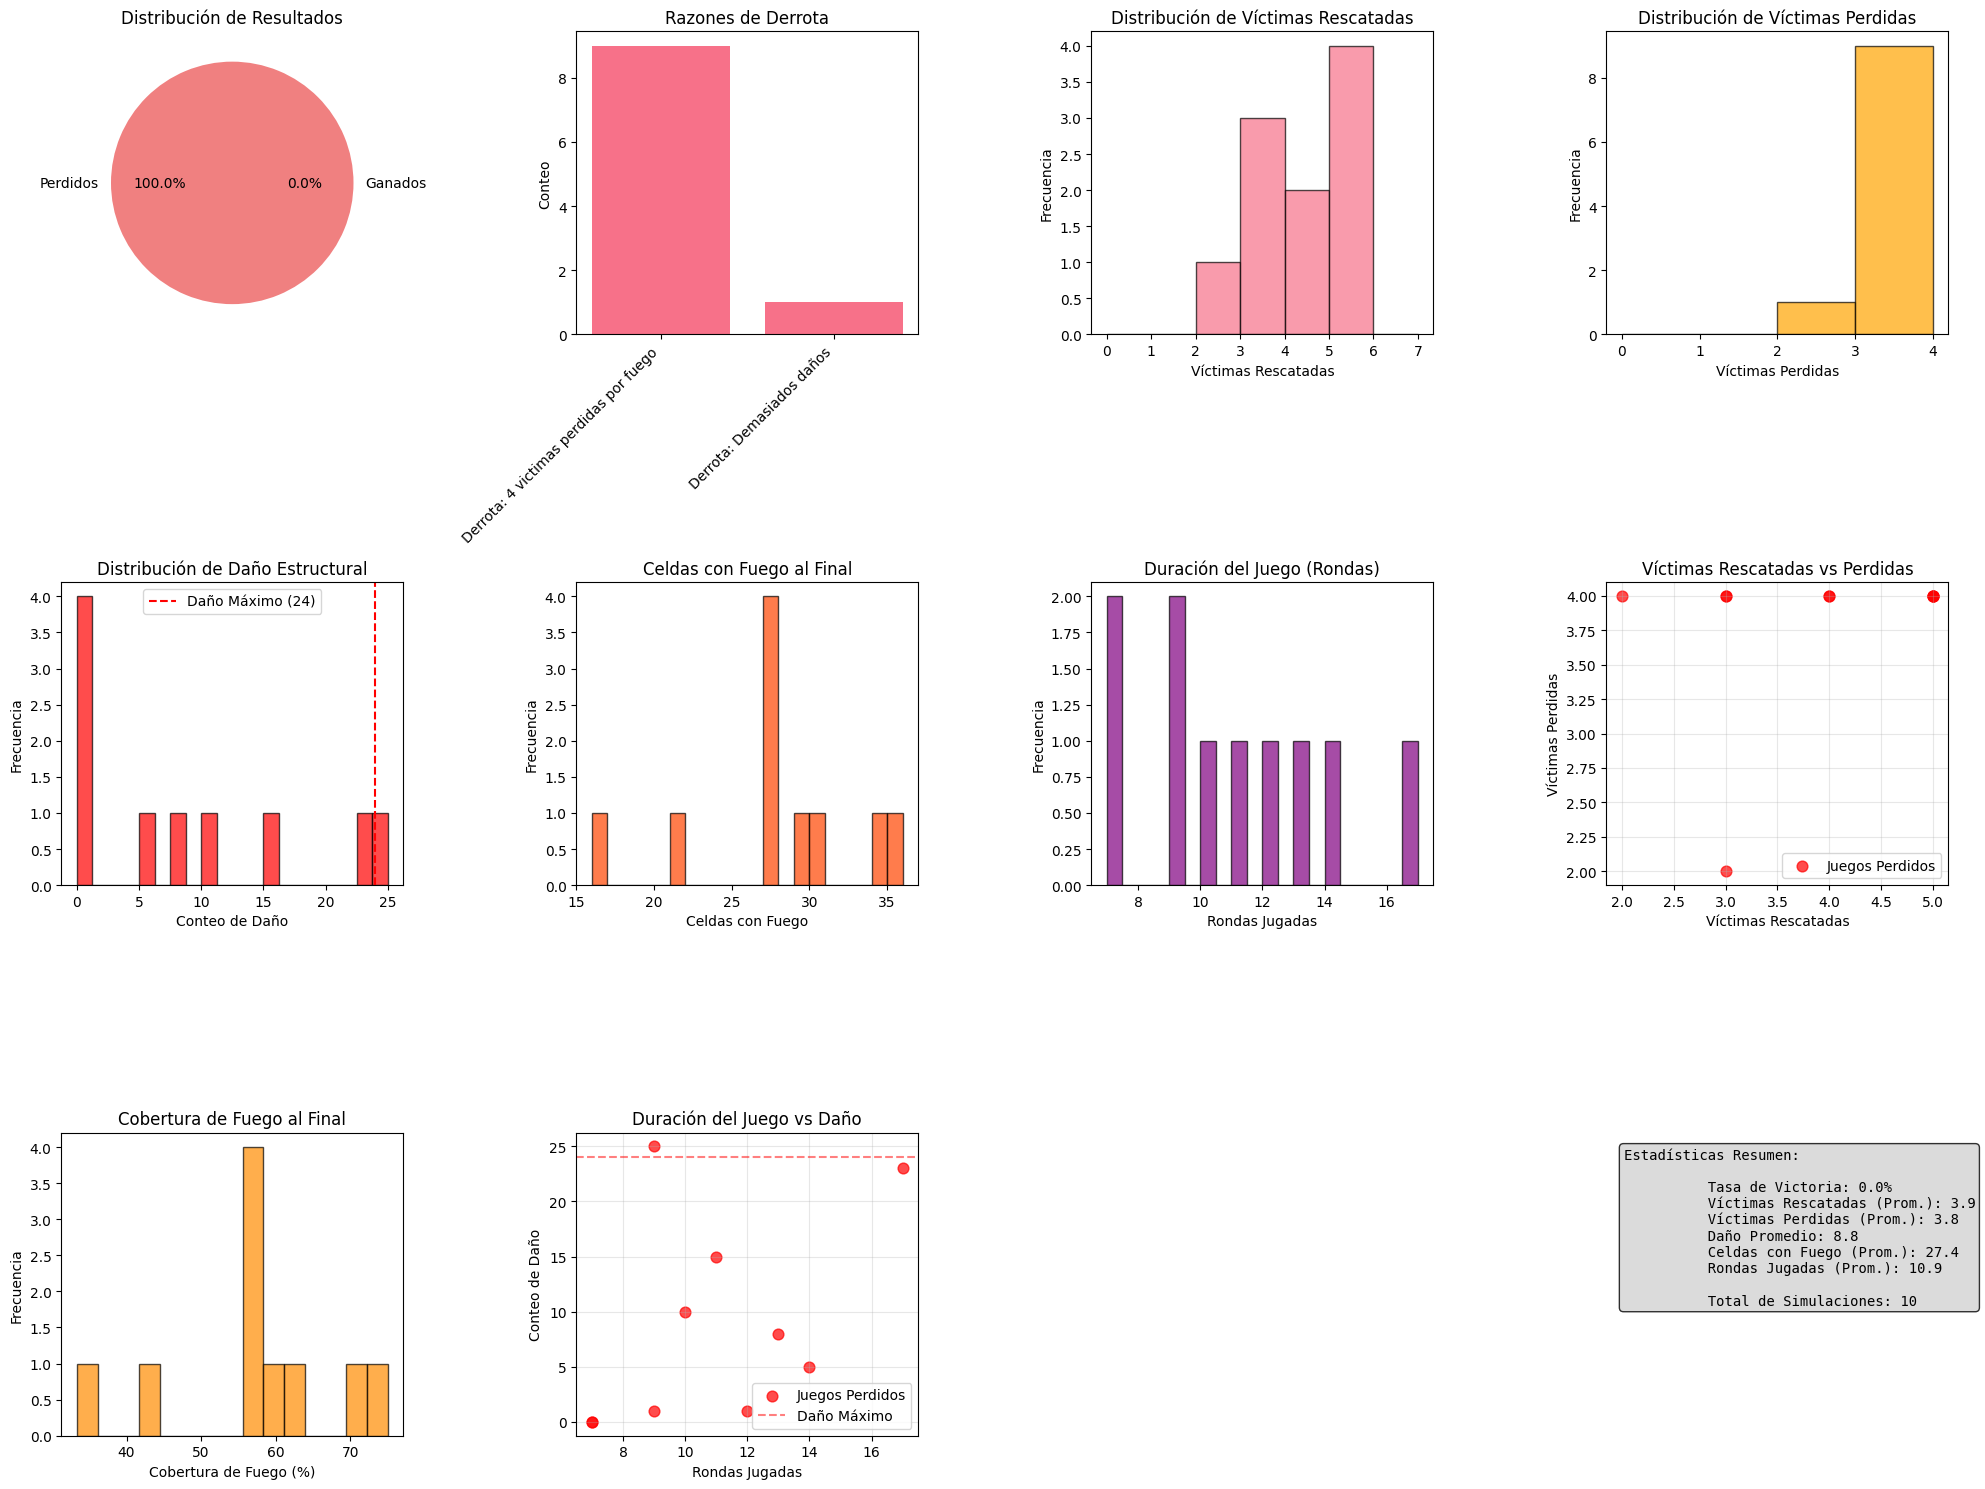

In [150]:
class BatchSimulationRunner:
    def __init__(self, grid_data):
        self.grid_data = grid_data
        self.results = []

    def run_single_simulation(self, sim_id: int, max_steps: int = 1000) -> Dict:
        print(f"Corriendo simulación {sim_id + 1}...")

        model = FireRescueModel(self.grid_data)

        step_count = 0
        while model.running and step_count < max_steps:
            model.step()
            step_count += 1

            if step_count >= max_steps:
                model.end_game(False, "Tiempo límite: Máximo de pasos alcanzado")
                break

        fire_count = np.sum(model.fire_states == FireState.FIRE)
        smoke_count = np.sum(model.fire_states == FireState.SMOKE)
        clear_count = np.sum(model.fire_states == FireState.CLEAR)
        total_cells = model.height * model.width

        result = {
            'simulation_id': sim_id + 1,
            'game_won': model.game_won,
            'game_lost': model.game_lost,
            'end_reason': model.end_reason,
            'rounds_played': model.round_count,
            'steps_taken': step_count,
            'rescued_victims': len(model.rescued_victims),
            'lost_victims': len(model.lost_victims),
            'damage_count': model.damage_count,
            'fire_cells': fire_count,
            'smoke_cells': smoke_count,
            'clear_cells': clear_count,
            'total_cells': total_cells,
            'fire_percentage': (fire_count / total_cells) * 100,
            'smoke_percentage': (smoke_count / total_cells) * 100,
            'clear_percentage': (clear_count / total_cells) * 100,
            'active_pois_remaining': len(model.active_pois),
            'revealed_pois': len(model.revealed_pois),
            'agents_knocked_out': sum(1 for agent in model.agent_list if agent.is_knocked_out()),
        }

        return result

    def run_batch_simulation(self, num_simulations: int = 10, max_steps: int = 1000):
        print(f"Iniciando simulación por lotes con {num_simulations} ejecuciones...")
        print("=" * 60)

        self.results = []

        for i in range(num_simulations):
            result = self.run_single_simulation(i, max_steps)
            self.results.append(result)

            status = "GANADA" if result['game_won'] else "PERDIDA"
            print(f"Sim {i+1:2d}: {status:4s} | Razón: {result['end_reason'][:30]:30s} | "
                  f"Rescatadas: {result['rescued_victims']:2d} | Perdidas: {result['lost_victims']:2d} | "
                  f"Daño: {result['damage_count']:2d} | Rondas: {result['rounds_played']:3d}")

        print("=" * 60)
        print("¡Simulación por lotes completada!")

    def generate_summary_statistics(self) -> Dict:
        if not self.results:
            return {}

        df = pd.DataFrame(self.results)

        total_games = len(self.results)
        games_won = df['game_won'].sum()
        games_lost = df['game_lost'].sum()
        win_rate = (games_won / total_games) * 100

        loss_reasons = defaultdict(int)
        for result in self.results:
            if result['game_lost']:
                loss_reasons[result['end_reason']] += 1

        stats = {
            'total_simulations': total_games,
            'games_won': games_won,
            'games_lost': games_lost,
            'win_rate_percentage': win_rate,
            'loss_reasons': dict(loss_reasons),

            'avg_rescued_victims': df['rescued_victims'].mean(),
            'std_rescued_victims': df['rescued_victims'].std(),
            'min_rescued_victims': df['rescued_victims'].min(),
            'max_rescued_victims': df['rescued_victims'].max(),

            'avg_lost_victims': df['lost_victims'].mean(),
            'std_lost_victims': df['lost_victims'].std(),
            'min_lost_victims': df['lost_victims'].min(),
            'max_lost_victims': df['lost_victims'].max(),

            'avg_damage': df['damage_count'].mean(),
            'std_damage': df['damage_count'].std(),
            'min_damage': df['damage_count'].min(),
            'max_damage': df['damage_count'].max(),

            'avg_fire_cells': df['fire_cells'].mean(),
            'std_fire_cells': df['fire_cells'].std(),
            'avg_fire_percentage': df['fire_percentage'].mean(),
            'std_fire_percentage': df['fire_percentage'].std(),

            'avg_smoke_cells': df['smoke_cells'].mean(),
            'std_smoke_cells': df['smoke_cells'].std(),
            'avg_smoke_percentage': df['smoke_percentage'].mean(),
            'std_smoke_percentage': df['smoke_percentage'].std(),

            'avg_clear_cells': df['clear_cells'].mean(),
            'std_clear_cells': df['clear_cells'].std(),
            'avg_clear_percentage': df['clear_percentage'].mean(),
            'std_clear_percentage': df['clear_percentage'].std(),

            'avg_rounds_played': df['rounds_played'].mean(),
            'std_rounds_played': df['rounds_played'].std(),
            'min_rounds_played': df['rounds_played'].min(),
            'max_rounds_played': df['rounds_played'].max(),

            'avg_steps_taken': df['steps_taken'].mean(),
            'std_steps_taken': df['steps_taken'].std(),
            'min_steps_taken': df['steps_taken'].min(),
            'max_steps_taken': df['steps_taken'].max(),

            'avg_agents_knocked_out': df['agents_knocked_out'].mean(),
            'avg_active_pois_remaining': df['active_pois_remaining'].mean(),
            'avg_revealed_pois': df['revealed_pois'].mean(),
        }

        return stats

    def print_summary_report(self):
        if not self.results:
            print("Sin resultados de simulación")
            return

        stats = self.generate_summary_statistics()

        print("\n" + "=" * 80)
        print("Resumen de las simulaciones")
        print("=" * 80)

        print(f"\nResultados:")
        print(f"   Total de Simulaciones: {stats['total_simulations']}")
        print(f"   Juegos Ganados: {stats['games_won']} ({stats['win_rate_percentage']:.1f}%)")
        print(f"   Juegos Perdidos: {stats['games_lost']} ({100-stats['win_rate_percentage']:.1f}%)")

        print(f"\n💀 RAZONES DE DERROTA:")
        for reason, count in stats['loss_reasons'].items():
            percentage = (count / stats['total_simulations']) * 100
            print(f"   {reason}: {count} juegos ({percentage:.1f}%)")

        print(f"\n🚑 ESTADÍSTICAS DE VÍCTIMAS:")
        print(f"   Víctimas Rescatadas (Promedio ± Desv. Est.): {stats['avg_rescued_victims']:.2f} ± {stats['std_rescued_victims']:.2f}")
        print(f"                    Rango: {stats['min_rescued_victims']:.0f} - {stats['max_rescued_victims']:.0f}")
        print(f"   Víctimas Perdidas (Promedio ± Desv. Est.):    {stats['avg_lost_victims']:.2f} ± {stats['std_lost_victims']:.2f}")
        print(f"                    Rango: {stats['min_lost_victims']:.0f} - {stats['max_lost_victims']:.0f}")

        print(f"\n🏗️  DAÑO ESTRUCTURAL:")
        print(f"   Daño Promedio:  {stats['avg_damage']:.2f} ± {stats['std_damage']:.2f}")
        print(f"   Rango de Daño:    {stats['min_damage']:.0f} - {stats['max_damage']:.0f}")

        print(f"\n🔥 ANÁLISIS DE PROPAGACIÓN DEL FUEGO:")
        print(f"   Celdas con Fuego:      {stats['avg_fire_cells']:.2f} ± {stats['std_fire_cells']:.2f} ({stats['avg_fire_percentage']:.1f}%)")
        print(f"   Celdas con Humo:     {stats['avg_smoke_cells']:.2f} ± {stats['std_smoke_cells']:.2f} ({stats['avg_smoke_percentage']:.1f}%)")
        print(f"   Celdas Limpias:     {stats['avg_clear_cells']:.2f} ± {stats['std_clear_cells']:.2f} ({stats['avg_clear_percentage']:.1f}%)")

        print(f"\n⏱️  DURACIÓN DEL JUEGO:")
        print(f"   Rondas Jugadas:   {stats['avg_rounds_played']:.2f} ± {stats['std_rounds_played']:.2f}")
        print(f"   Rango:           {stats['min_rounds_played']:.0f} - {stats['max_rounds_played']:.0f}")
        print(f"   Pasos Realizados:     {stats['avg_steps_taken']:.2f} ± {stats['std_steps_taken']:.2f}")
        print(f"   Rango:           {stats['min_steps_taken']:.0f} - {stats['max_steps_taken']:.0f}")

        print(f"\n📈 ESTADÍSTICAS ADICIONALES:")
        print(f"   Promedio Agentes KO:   {stats['avg_agents_knocked_out']:.2f}")
        print(f"   Promedio POIs Restantes:   {stats['avg_active_pois_remaining']:.2f}")
        print(f"   Promedio POIs Encontrados:  {stats['avg_revealed_pois']:.2f}")

        print("=" * 80)

    def create_visualization_plots(self, save_plots: bool = False):
        if not self.results:
            print("No hay resultados de simulación disponibles para graficar!")
            return

        df = pd.DataFrame(self.results)

        # Set up the plotting style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Win/Loss Pie Chart
        ax1 = plt.subplot(3, 4, 1)
        win_loss_data = [df['game_won'].sum(), df['game_lost'].sum()]
        win_loss_labels = ['Ganados', 'Perdidos']
        colors = ['lightgreen', 'lightcoral']
        plt.pie(win_loss_data, labels=win_loss_labels, autopct='%1.1f%%', colors=colors)
        plt.title('Distribución de Resultados')

        # 2. Loss Reasons Bar Chart
        ax2 = plt.subplot(3, 4, 2)
        loss_df = df[df['game_lost'] == True]
        if not loss_df.empty:
            loss_reasons = loss_df['end_reason'].value_counts()
            plt.bar(range(len(loss_reasons)), loss_reasons.values)
            plt.xticks(range(len(loss_reasons)), loss_reasons.index, rotation=45, ha='right')
            plt.title('Razones de Derrota')
            plt.ylabel('Conteo')
        else:
            plt.text(0.5, 0.5, '¡Sin Derrotas!', ha='center', va='center', transform=ax2.transAxes)
            plt.title('Razones de Derrota')

        # 3. Rescued Victims Distribution
        ax3 = plt.subplot(3, 4, 3)
        plt.hist(df['rescued_victims'], bins=range(0, 8), alpha=0.7, edgecolor='black')
        plt.xlabel('Víctimas Rescatadas')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Víctimas Rescatadas')
        plt.xticks(range(0, 8))

        # 4. Lost Victims Distribution
        ax4 = plt.subplot(3, 4, 4)
        plt.hist(df['lost_victims'], bins=range(0, 5), alpha=0.7, edgecolor='black', color='orange')
        plt.xlabel('Víctimas Perdidas')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Víctimas Perdidas')
        plt.xticks(range(0, 5))

        # 5. Damage Distribution
        ax5 = plt.subplot(3, 4, 5)
        plt.hist(df['damage_count'], bins=20, alpha=0.7, edgecolor='black', color='red')
        plt.xlabel('Conteo de Daño')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Daño Estructural')
        plt.axvline(x=24, color='red', linestyle='--', label='Daño Máximo (24)')
        plt.legend()

        # 6. Fire Cells Distribution
        ax6 = plt.subplot(3, 4, 6)
        plt.hist(df['fire_cells'], bins=20, alpha=0.7, edgecolor='black', color='orangered')
        plt.xlabel('Celdas con Fuego')
        plt.ylabel('Frecuencia')
        plt.title('Celdas con Fuego al Final')

        # 7. Game Duration (Rounds)
        ax7 = plt.subplot(3, 4, 7)
        plt.hist(df['rounds_played'], bins=20, alpha=0.7, edgecolor='black', color='purple')
        plt.xlabel('Rondas Jugadas')
        plt.ylabel('Frecuencia')
        plt.title('Duración del Juego (Rondas)')

        # 8. Scatter: Rescued vs Lost Victims
        ax8 = plt.subplot(3, 4, 8)
        won_games = df[df['game_won'] == True]
        lost_games = df[df['game_lost'] == True]
        if not won_games.empty:
            plt.scatter(won_games['rescued_victims'], won_games['lost_victims'],
                       color='green', label='Juegos Ganados', alpha=0.7, s=60)
        if not lost_games.empty:
            plt.scatter(lost_games['rescued_victims'], lost_games['lost_victims'],
                       color='red', label='Juegos Perdidos', alpha=0.7, s=60)
        plt.xlabel('Víctimas Rescatadas')
        plt.ylabel('Víctimas Perdidas')
        plt.title('Víctimas Rescatadas vs Perdidas')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 9. Fire Percentage Distribution
        ax9 = plt.subplot(3, 4, 9)
        plt.hist(df['fire_percentage'], bins=15, alpha=0.7, edgecolor='black', color='darkorange')
        plt.xlabel('Cobertura de Fuego (%)')
        plt.ylabel('Frecuencia')
        plt.title('Cobertura de Fuego al Final')

        # 10. Rounds vs Damage Scatter
        ax10 = plt.subplot(3, 4, 10)
        if not won_games.empty:
            plt.scatter(won_games['rounds_played'], won_games['damage_count'],
                       color='green', label='Juegos Ganados', alpha=0.7, s=60)
        if not lost_games.empty:
            plt.scatter(lost_games['rounds_played'], lost_games['damage_count'],
                       color='red', label='Juegos Perdidos', alpha=0.7, s=60)
        plt.xlabel('Rondas Jugadas')
        plt.ylabel('Conteo de Daño')
        plt.title('Duración del Juego vs Daño')
        plt.axhline(y=24, color='red', linestyle='--', alpha=0.5, label='Daño Máximo')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 11. Summary Statistics Text
        ax11 = plt.subplot(3, 4, 12)
        stats = self.generate_summary_statistics()
        summary_text = f"""Estadísticas Resumen:

          Tasa de Victoria: {stats['win_rate_percentage']:.1f}%
          Víctimas Rescatadas (Prom.): {stats['avg_rescued_victims']:.1f}
          Víctimas Perdidas (Prom.): {stats['avg_lost_victims']:.1f}
          Daño Promedio: {stats['avg_damage']:.1f}
          Celdas con Fuego (Prom.): {stats['avg_fire_cells']:.1f}
          Rondas Jugadas (Prom.): {stats['avg_rounds_played']:.1f}

          Total de Simulaciones: {stats['total_simulations']}"""

        plt.text(0.05, 0.95, summary_text, transform=ax11.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def run_fire_rescue_batch_analysis(num_simulations: int = 10):
    runner = BatchSimulationRunner(grid_data)
    runner.run_batch_simulation(num_simulations)
    runner.print_summary_report()
    runner.create_visualization_plots(save_plots=True)

    return runner

if __name__ == "__main__":
    batch_runner = run_fire_rescue_batch_analysis(num_simulations=10)
